# MNIST Digit Generator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms as T

In [2]:
data_transforms = T.Compose([
  T.ToTensor(),
  T.Normalize((0.5, ), (0.5, ))
])

In [3]:
train_data = datasets.MNIST('data', train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST('data', train=False, download=True, transform=data_transforms)

d:\ProgramFiles\anaconda\envs\fastapi-ml\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
len(train_data), len(test_data)

(60000, 10000)

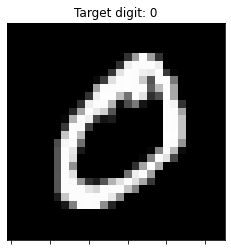

In [5]:
def plot_image(img, label=None, cmap='gray'):
  img = img.squeeze(0)
  plt.tick_params(left=False, bottom=True, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title("Target digit: " + str(label))
  plt.imshow(img, cmap=cmap)


plot_image(train_data[1][0], train_data[1][1])

In [6]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=4)

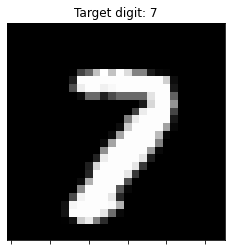

In [7]:
def check_dataloader(dloader):
  for images, labels in train_loader:
    plot_image(images[0].numpy(), labels[0].item())

    break

check_dataloader(train_loader)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Designing the GAN

##### Desigining the Discriminator

In [9]:
class Discriminator(nn.Module):

  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()

    self.image_size, self.hidden_size = image_size, hidden_size

    self.lin1 = nn.Linear(image_size, hidden_size)
    self.lrelu = nn.LeakyReLU(0.02)
    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, 1)
    
  def forward(self, X):
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return F.sigmoid(self.lin3(X))

  def __repr__(self) -> str:
    return f"Linear({self.image_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, 1) -> Sigmoid()"


In [10]:
image_size, hidden_size = 784, 256
disc = Discriminator(image_size, hidden_size)
disc.to(device)

Linear(784, 256) -> LeakyReLU(0.02) ->
Linear(256, 256) -> LeakyReLU(0.02) ->
Linear(256, 1) -> Sigmoid()

##### Designing the Generator

In [11]:
class Generator(nn.Module):

  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    self.lin1 = nn.Linear(1, hidden_size)
    self.lrelu = nn.LeakyReLU(0.02)

    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, image_size)


  def forward(self, X):
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return torch.tanh(self.lin3(X))

In [12]:
latent_size = 64
gen = Generator(latent_size, hidden_size, image_size)
gen.to(device)

Generator(
  (lin1): Linear(in_features=1, out_features=256, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.02)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=784, bias=True)
)

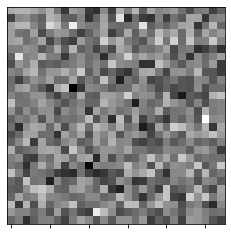

In [13]:
# testing out the generator
y = gen(torch.rand((latent_size, ), device=device))
plot_image(y.reshape(1, 28, 28).detach().cpu().numpy())

### Training the Discriminator

In [14]:
criterion = nn.BCELoss()
lr = 0.01

optimizers = {
  disc: torch.optim.Adam(disc.parameters(), lr=lr),
  gen: torch.optim.Adam(gen.parameters(), lr=lr)
}

In [17]:
def reset_grad(optims):
  for optim in optims:
    optim.zero_grad()

In [42]:
def get_accuracy_binary(outputs, target_class):
  """Returns ( num_correct, accuracy )"""
  len_outputs = outputs.size(0)
  num_correct = (torch.round(outputs) == target_class).sum()
  return num_correct.item(), (num_correct / len_outputs)


In [43]:
a = torch.rand((3, 1))
a, get_accuracy_binary(a, 1)

(tensor([[0.8876],
         [0.6232],
         [0.2775]]),
 (2, tensor(0.6667)))

In [20]:
torch.round(torch.tensor(0.5))

tensor(0.)

In [ ]:
def train_discriminator(images):
  real_labels = torch.ones((batch_size, 1), device=device)
  fake_labels = torch.ones((batch_size, 1), device=device)

  # train on real data, discriminator should aim to get better
  outputs = disc(images)
  d_real = criterion(outputs, real_labels)
  # real_score = output